In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
import scipy
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler 
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import log_loss
# from tqdm.notebook import tqdm
# from time import time
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

In [4]:
os.listdir('lish-moa')
train_features = pd.read_csv('lish-moa/train_features.csv')
train_targets_scored = pd.read_csv('lish-moa/train_targets_scored.csv')
train_targets_nonscored = pd.read_csv('lish-moa/train_targets_nonscored.csv')
test_features = pd.read_csv('lish-moa/test_features.csv')
submission = pd.read_csv('lish-moa/sample_submission.csv')

In [5]:
# This is inspired by the discussion here: https://www.kaggle.com/c/lish-moa/discussion/180165
train = train_features.merge(train_targets_scored, on = 'sig_id')
cols = [c for c in train_targets_scored.columns] + ['cp_type']
train[cols].groupby('cp_type').sum().sum(1)
# As a result, if cp_type is ctl_vehicle, we predict all to be zero

cp_type
ctl_vehicle        0
trt_cp         16844
dtype: int64

In [6]:
train = train_features

# Data Preprocessing and Feature Engineering
my plan here is to try PCA or tsne, then use Random Forest and XGBoost. Lastly, Neural Networks

In [7]:
# removing cases when cp_type is ctl_vehicle
#train = train[train['cp_type']!='ctl_vehicle'].reset_index(drop=True)
# transform the TWO categorical variables into numerical variables
# this is label encoding, may try one hot encoding later
train['cp_time'] = train['cp_time'].map({24:0, 48:1, 72:2})
train['cp_dose'] = train['cp_dose'].map({'D1':0,'D2':1})
train['cp_type'] = train['cp_type'].map({'trt_cp':0,'ctl_vehicle':1})
#make id index
#train = train.set_index(['sig_id'])

train

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,0,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,0,2,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,0,1,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,0,1,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,0,2,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,0,0,1,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,...,0.1969,0.0262,-0.8121,0.3434,0.5372,-0.3246,0.0631,0.9171,0.5258,0.4680
23810,id_fffb70c0c,0,0,1,-1.3260,0.3478,-0.3743,0.9905,-0.7178,0.6621,...,0.4286,0.4426,0.0423,-0.3195,-0.8086,-0.9798,-0.2084,-0.1224,-0.2715,0.3689
23811,id_fffc1c3f4,1,1,1,0.3942,0.3756,0.3109,-0.7389,0.5505,-0.0159,...,0.5409,0.3755,0.7343,0.2807,0.4116,0.6422,0.2256,0.7592,0.6656,0.3808
23812,id_fffcb9e7c,0,0,0,0.6660,0.2324,0.4392,0.2044,0.8531,-0.0343,...,-0.1105,0.4258,-0.2012,0.1506,1.5230,0.7101,0.1732,0.7015,-0.6290,0.0740


In [8]:
GENES = [col for col in train_features.columns if col.startswith('g-')]
CELLS = [col for col in train_features.columns if col.startswith('c-')]
train

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,0,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,0,2,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,0,1,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,0,1,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,0,2,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,0,0,1,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,...,0.1969,0.0262,-0.8121,0.3434,0.5372,-0.3246,0.0631,0.9171,0.5258,0.4680
23810,id_fffb70c0c,0,0,1,-1.3260,0.3478,-0.3743,0.9905,-0.7178,0.6621,...,0.4286,0.4426,0.0423,-0.3195,-0.8086,-0.9798,-0.2084,-0.1224,-0.2715,0.3689
23811,id_fffc1c3f4,1,1,1,0.3942,0.3756,0.3109,-0.7389,0.5505,-0.0159,...,0.5409,0.3755,0.7343,0.2807,0.4116,0.6422,0.2256,0.7592,0.6656,0.3808
23812,id_fffcb9e7c,0,0,0,0.6660,0.2324,0.4392,0.2044,0.8531,-0.0343,...,-0.1105,0.4258,-0.2012,0.1506,1.5230,0.7101,0.1732,0.7015,-0.6290,0.0740


In [9]:
# #not utilized
# #standardize data
# for col in (GENES + CELLS):
#     transformer = QuantileTransformer(random_state=86, output_distribution="normal")
#     vec = train[col].values.reshape(len(train[col].values), 1)
#     transformer.fit(vec)

#     train[col] = transformer.transform(vec).reshape(1, len(train[col].values))[0]
# #this step is utterly unnecessary, I guess this values were standardized before releasing
# train

# this part is for presetation
PCA-In our data we have about 775 gene expression variables and 100 cell viability variables and 23000+ records in the training dataset. Building an ensemble learning model on this dataset would take a large amount of time, and also we noticed that a lot of cell viability variables are correlated to each other. Therefore we would be looking at dimensionality reduction to overcome these issues. Here we would be implementing Principal Component Analysis(PCA) to achieve dimensionality reduction.
When to use PCA?
When we want to reduce the number of independent variables but still don't want to lose the information available from those variables.
When we want to ensure our variables are independent of each other
When we are comfortable with making our independent variables less interpretable
Steps we will follow to implement PCA -
Remove outliers and standardize the variables
Covariance Matrix computation and calculation of Eigen Values. The PCA function in sklearn package takes care of these details and we don't have to worry about them
Plot the explained variance by Principal Components and select the number of principal components to include.

In [178]:
# pca = PCA().fit(train)

# fig, ax = plt.subplots()
# xi = np.arange(0,874, step=1)
# y = np.cumsum(pca.explained_variance_ratio_)

# plt.ylim(0.0,1.2)
# plt.plot(xi, y)

# plt.xlabel('Number of Components')
# #plt.xticks(np.arange(0, 750, step=50)) #change from 0-based array index to 1-based human-readable label
# plt.ylabel('Cumulative variance (%)')
# plt.title('The number of components needed to explain variance')

# plt.axhline(y=0.90, linestyle='-')
# plt.text(0.75, 0.3, '95% cut-off threshold')#, color = 'red', fontsize=16)

# ax.grid(axis='x')
# plt.show()
# #we need ~550 pc

In [10]:
def remove_outliers(col):
    col[col>3]=3
    col[col<-3]=-3
    return col
train=train.iloc[:,1:].apply(remove_outliers)
train

<ipython-input-10-77a055c1dc10>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[col>3]=3
<ipython-input-10-77a055c1dc10>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[col<-3]=-3


,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,0,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,0,2,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,0,1,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,0,1,0,-0.5138,-0.2491,-0.2656,0.5288,3.0000,-0.8095,-1.9590,...,-2.0990,-0.6441,-3.0000,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,0,2,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,0,0,1,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,0.5773,...,0.1969,0.0262,-0.8121,0.3434,0.5372,-0.3246,0.0631,0.9171,0.5258,0.4680
23810,0,0,1,-1.3260,0.3478,-0.3743,0.9905,-0.7178,0.6621,-0.2252,...,0.4286,0.4426,0.0423,-0.3195,-0.8086,-0.9798,-0.2084,-0.1224,-0.2715,0.3689
23811,1,1,1,0.3942,0.3756,0.3109,-0.7389,0.5505,-0.0159,-0.2541,...,0.5409,0.3755,0.7343,0.2807,0.4116,0.6422,0.2256,0.7592,0.6656,0.3808
23812,0,0,0,0.6660,0.2324,0.4392,0.2044,0.8531,-0.0343,0.0323,...,-0.1105,0.4258,-0.2012,0.1506,1.5230,0.7101,0.1732,0.7015,-0.6290,0.0740


,c-0,c-1,c-2,c-3,c-4,c-5,c-6,c-7,c-8,c-9,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,-0.0600,0.1083,0.6864,0.4043,0.4213,-0.6797,0.2888,0.4323,-0.3381,0.3407,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,0.0927,0.2723,0.2772,0.7776,0.3679,0.5696,0.2835,1.4080,0.3745,0.6775,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,-0.1312,-1.4640,0.3394,-1.7790,0.2188,0.5826,-0.7513,0.0543,0.7182,-0.4159,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,-0.3998,-3.0000,-2.7350,-1.9630,-2.8610,-1.2670,-2.5830,-0.5036,-3.0000,-1.8510,...,-2.0990,-0.6441,-3.0000,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,-0.3774,0.7364,-0.1659,0.2341,1.0060,0.3204,-0.0852,-0.2284,-0.2533,-0.3174,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,0.4224,0.1871,-0.4822,0.3713,0.4754,0.9512,0.4650,0.3005,0.0338,-0.7734,...,0.1969,0.0262,-0.8121,0.3434,0.5372,-0.3246,0.0631,0.9171,0.5258,0.4680
23810,0.2144,0.4350,0.1174,1.3960,-0.6772,0.2316,-0.5396,0.0581,0.6067,-0.4622,...,0.4286,0.4426,0.0423,-0.3195,-0.8086,-0.9798,-0.2084,-0.1224,-0.2715,0.3689
23811,1.0650,0.6329,0.3742,0.1237,0.6147,0.4589,-0.2372,1.1160,0.4623,0.2830,...,0.5409,0.3755,0.7343,0.2807,0.4116,0.6422,0.2256,0.7592,0.6656,0.3808
23812,0.5377,1.3240,0.9679,0.1419,1.2230,0.3404,-0.1589,0.8667,0.7749,-0.1458,...,-0.1105,0.4258,-0.2012,0.1506,1.5230,0.7101,0.1732,0.7015,-0.6290,0.0740


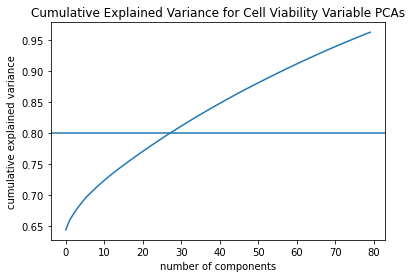

In [33]:
#pc for cells

train_c=train.loc[:, CELLS]
x = StandardScaler().fit_transform(train_c)
pca_c = PCA(n_components=80)
principalComponents = pca_c.fit_transform(x)
principalDf_c = pd.DataFrame(data = principalComponents)

plt.plot(np.cumsum(pca_c.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axhline(y=0.80, linestyle='-')
plt.title('Cumulative Explained Variance for Cell Viability Variable PCAs')
train_c

,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,...,g-762,g-763,g-764,g-765,g-766,g-767,g-768,g-769,g-770,g-771
0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,...,-0.5055,-0.3167,1.0930,0.0084,0.8611,-0.5582,0.3008,1.6490,0.2968,-0.0224
1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,...,-0.5338,0.0224,-0.4831,0.2128,-0.6999,-0.1214,-0.1626,-0.3340,-0.3289,-0.2718
2,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,...,2.5770,0.2356,1.3230,-1.3730,-0.2682,0.8427,0.5797,0.3143,0.8133,0.7923
3,-0.5138,-0.2491,-0.2656,0.5288,3.0000,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,...,-0.1292,3.0000,1.2720,-0.4733,-2.0560,0.5699,0.1996,0.4374,0.1588,-0.0343
4,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,...,-0.6904,2.0540,-0.3131,-0.0809,0.3910,1.7660,-1.0020,-0.7534,0.5000,-0.6269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,0.5773,0.3055,-0.4726,0.1269,...,0.7790,0.5393,0.4112,-0.5059,0.0240,-0.2297,0.7221,0.5099,-0.1423,0.3806
23810,-1.3260,0.3478,-0.3743,0.9905,-0.7178,0.6621,-0.2252,-0.5565,0.5112,0.6727,...,-0.0858,0.3606,-0.0248,0.0672,-0.5901,-0.1022,0.5247,0.5438,-0.1875,-0.4751
23811,0.3942,0.3756,0.3109,-0.7389,0.5505,-0.0159,-0.2541,0.1745,-0.0340,0.4865,...,0.1796,0.3488,0.0927,0.5166,-0.3099,-0.5946,0.9778,0.2326,-0.6191,0.3603
23812,0.6660,0.2324,0.4392,0.2044,0.8531,-0.0343,0.0323,0.0463,0.4299,-0.7985,...,-0.1410,1.9590,0.8224,1.2500,-3.0000,-2.8720,0.1794,0.3109,-0.3491,-0.4741


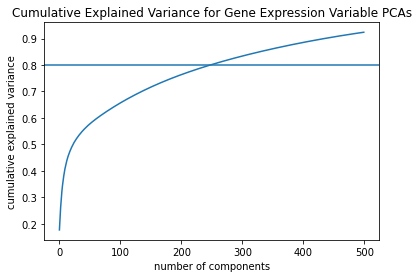

In [12]:
#pc for gene

train_g=train.loc[:, GENES]
x = StandardScaler().fit_transform(train_g)
pca_g = PCA(n_components=500)
principalComponents = pca_g.fit_transform(x)
principalDf_g = pd.DataFrame(data = principalComponents)

plt.plot(np.cumsum(pca_g.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axhline(y=0.80, linestyle='-')
plt.title('Cumulative Explained Variance for Gene Expression Variable PCAs')
train_g

For now, I will choose 0.8 -- that gives me 240 principle components for genes and 26 pc for cells

In [13]:

#this part was inspried by one of the notebooks
pca_c=principalDf_c.iloc[:,:26]
names=[]
for i in range(1,27):
    var='pca_c'+str(i)
    names.append(var)
pca_c.columns=names

pca_g=principalDf_g.iloc[:,:240]
names=[]
for i in range(1,241):
    var='pca_g'+str(i)
    names.append(var)
pca_g.columns=names


pca_cg=pd.merge(pca_c, pca_g, left_index=True, right_index=True)
train_pca = pd.merge(train.iloc[:,:3], pca_cg, left_index=True, right_index=True)
train_pca

,cp_type,cp_time,cp_dose,pca_c1,pca_c2,pca_c3,pca_c4,pca_c5,pca_c6,pca_c7,...,pca_g231,pca_g232,pca_g233,pca_g234,pca_g235,pca_g236,pca_g237,pca_g238,pca_g239,pca_g240
0,0,0,0,-4.817148,1.062926,-0.589636,-0.575730,-1.081031,-0.548887,-0.472183,...,-0.223639,0.133575,-0.871727,0.101917,-0.206851,0.133056,0.101464,0.886158,-1.586277,0.294565
1,0,2,0,-4.997670,-0.215408,-0.167323,0.232766,-0.274137,-0.077560,-0.286073,...,-0.277424,-0.404145,0.019088,-0.091105,1.217435,0.218514,0.131991,0.087781,0.908611,0.074996
2,0,1,0,0.045162,0.530170,0.417546,-0.039593,0.172192,-0.004675,-0.399574,...,0.663110,0.117897,-0.097634,-1.115766,-0.511548,-0.065278,1.467347,1.536210,0.105558,-0.532529
3,0,1,0,14.455510,5.272821,-1.244755,3.424090,-2.339055,0.635806,0.409224,...,-1.204965,1.321544,-0.513018,-0.844421,-0.180099,0.774417,-0.422997,-0.497456,0.557420,0.644898
4,0,2,1,-3.931571,0.596221,0.255306,-0.510133,0.111545,0.150078,0.163462,...,0.256454,1.235980,-0.273024,-0.274744,-0.240125,0.948021,-0.026208,0.051163,0.376393,0.401757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,0,0,1,-3.921035,-0.098002,-0.460143,1.025173,0.441582,0.137145,-0.885680,...,-0.633394,-0.556416,1.185370,-0.453098,-0.987932,1.650052,-1.709162,0.274779,-0.316664,-0.103777
23810,0,0,1,-1.648615,-0.030032,-0.499233,-2.038884,0.518411,0.671420,-0.300262,...,-0.892414,0.609377,0.745017,0.760582,-0.413170,-0.988060,-1.773566,-0.038574,0.344984,-0.023455
23811,1,1,1,-5.895690,0.718708,-0.829521,0.271426,-0.187698,-0.408464,-0.029757,...,1.165753,0.014225,0.771122,-0.840293,-0.690562,-0.172586,0.728383,-0.955340,0.545388,-0.434309
23812,0,0,0,-5.389047,0.856159,-0.879516,-0.391346,0.937524,-0.979720,1.128265,...,-0.134373,-0.348500,-0.969733,-0.336896,-0.675034,0.703557,-0.019859,-0.184609,-0.928936,-0.047285


NOW THAT WE HAVE CREATED OUR PRINCIPLE COMPONENTS, IT'S TIME TO START MODEL FITTING
I WILL FIRST TRY LOGISTIC REGRESSION, THE MOST BASIC CLASSIFER. 
NOTE THAT LOGISTIC REGRESSION ONLY SUPPORTS BINARY CLASSIFICATION AS DEFAULT, BUT WE CAN SOLVE THAT EASILY BY USING  MultiOutputClassifier wrapper in sklearn

In [39]:
train_pca.drop(['cp_type'], axis=1)

,cp_time,cp_dose,pca_c1,pca_c2,pca_c3,pca_c4,pca_c5,pca_c6,pca_c7,pca_c8,...,pca_g231,pca_g232,pca_g233,pca_g234,pca_g235,pca_g236,pca_g237,pca_g238,pca_g239,pca_g240
0,0,0,-4.817148,1.062926,-0.589636,-0.575730,-1.081031,-0.548887,-0.472183,0.122344,...,-0.223639,0.133575,-0.871727,0.101917,-0.206851,0.133056,0.101464,0.886158,-1.586277,0.294565
1,2,0,-4.997670,-0.215408,-0.167323,0.232766,-0.274137,-0.077560,-0.286073,0.377455,...,-0.277424,-0.404145,0.019088,-0.091105,1.217435,0.218514,0.131991,0.087781,0.908611,0.074996
2,1,0,0.045162,0.530170,0.417546,-0.039593,0.172192,-0.004675,-0.399574,-0.263215,...,0.663110,0.117897,-0.097634,-1.115766,-0.511548,-0.065278,1.467347,1.536210,0.105558,-0.532529
3,1,0,14.455510,5.272821,-1.244755,3.424090,-2.339055,0.635806,0.409224,1.756998,...,-1.204965,1.321544,-0.513018,-0.844421,-0.180099,0.774417,-0.422997,-0.497456,0.557420,0.644898
4,2,1,-3.931571,0.596221,0.255306,-0.510133,0.111545,0.150078,0.163462,-0.400974,...,0.256454,1.235980,-0.273024,-0.274744,-0.240125,0.948021,-0.026208,0.051163,0.376393,0.401757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,0,1,-3.921035,-0.098002,-0.460143,1.025173,0.441582,0.137145,-0.885680,0.619521,...,-0.633394,-0.556416,1.185370,-0.453098,-0.987932,1.650052,-1.709162,0.274779,-0.316664,-0.103777
23810,0,1,-1.648615,-0.030032,-0.499233,-2.038884,0.518411,0.671420,-0.300262,0.293229,...,-0.892414,0.609377,0.745017,0.760582,-0.413170,-0.988060,-1.773566,-0.038574,0.344984,-0.023455
23811,1,1,-5.895690,0.718708,-0.829521,0.271426,-0.187698,-0.408464,-0.029757,0.342337,...,1.165753,0.014225,0.771122,-0.840293,-0.690562,-0.172586,0.728383,-0.955340,0.545388,-0.434309
23812,0,0,-5.389047,0.856159,-0.879516,-0.391346,0.937524,-0.979720,1.128265,-0.438819,...,-0.134373,-0.348500,-0.969733,-0.336896,-0.675034,0.703557,-0.019859,-0.184609,-0.928936,-0.047285


In [ ]:
#还没用
# Function to extract common stats features
def fe_stats(train, test):
    
    features_g = list(train.columns[4:776])
    features_c = list(train.columns[776:876])
    
    for df in [train, test]:
        df['g_mean'] = df[features_g].mean(axis = 1)
        df['g_std'] = df[features_g].std(axis = 1)
        df['c_mean'] = df[features_c].mean(axis = 1)
        df['c_std'] = df[features_c].std(axis = 1)
        df['gc_mean'] = df[features_g + features_c].mean(axis = 1)
        df['gc_std'] = df[features_g + features_c].std(axis = 1)

        
    return train, test

# Train-test split

In [14]:
# 2:1
X_train, X_test, y_train, y_test = train_test_split(
    train_pca, train_targets_scored.iloc[:,1:], test_size=0.33, random_state=42)

An intuitive approach to solving multi-label problem is to decompose it into multiple independent binary classification problems 
In an “one-to-rest” strategy, one could build multiple independent classifiers and, for an unseen instance, choose the class for which the confidence is maximized.
The main assumption here is that the labels are mutually exclusive. You do not consider any underlying correlation between the classes in this method.

In [15]:
from sklearn.neighbors import KNeighborsClassifier
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)
knn_predictions_prob = knn_classifier.predict_proba(X_test)
knn_predictions = knn_classifier.predict(X_test)
from sklearn.metrics import confusion_matrix


In [48]:
from sklearn.metrics import multilabel_confusion_matrix

example = multilabel_confusion_matrix(y_test, knn_predictions)[-12]
example

array([[7822,    1],
       [  22,   14]])

In [27]:
from sklearn.metrics import roc_auc_score
try:
    roc_auc_score(y_test,knn_predictions)
except ValueError:
    pass


In [49]:
example[0][1] = 0
example[1][0] = 11
example[1][1] = 26
example

array([[7822,    0],
       [  11,   26]])

In [25]:
y_test.shape

(7859, 206)

In [20]:
from sklearn.datasets import load_breast_cancer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(y_test.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test.iloc[:, i], knn_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

/Users/yianding/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


In [ ]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

# # Import some data to play with
# iris = datasets.load_iris()
# X = iris.data
# y = iris.target

# Binarize the output
y = label_binarize(train_targets_scored.iloc[:,1:], classes=classe)
n_classes = y.shape[1]
random_state = np.random.RandomState(39)

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    train_pca, y, test_size=0.33, random_state=42)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


Automatically created module for IPython interactive environment


In [263]:
classe = []
for i in range(206):
    classe.append(i)

In [81]:
X_train, X_holdout, y_train, y_holdout = train_test_split(
    train_pca, train_targets_scored.iloc[:,1:], test_size=0.2, random_state=74)
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=0.33, random_state=42)

from sklearn.metrics import multilabel_confusion_matrix
categories = list(y_train.columns)
# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),
            ])
matrix = []
for category in categories:
    print('**Processing {} comments...**'.format(category))
    
    # Training logistic regression model on train data
    LogReg_pipeline.fit(X_train, y_train[category])
    
    # calculating test accuracy
    prediction = LogReg_pipeline.predict(X_holdout)
    print('Test accuracy is {}'.format(accuracy_score(y_holdout[category], prediction)))
    m = multilabel_confusion_matrix(y_holdout[category], prediction)
    print(m)
    a = 1
    if len(m) <2:
        a = 0
    matrix.append(multilabel_confusion_matrix(y_holdout[category], prediction)[a])
    print("\n")

**Processing 5-alpha_reductase_inhibitor comments...**
Test accuracy is 0.9991601931555742
[[[   0    4]
  [   0 4759]]

 [[4759    0]
  [   4    0]]]


**Processing 11-beta-hsd1_inhibitor comments...**
Test accuracy is 0.9985303380222549
[[[   0    7]
  [   0 4756]]

 [[4756    0]
  [   7    0]]]


**Processing acat_inhibitor comments...**
Test accuracy is 0.9993701448666806
[[[   0    3]
  [   0 4760]]

 [[4760    0]
  [   3    0]]]


**Processing acetylcholine_receptor_agonist comments...**
Test accuracy is 0.9924417384001679
[[[   0   35]
  [   1 4727]]

 [[4727    1]
  [  35    0]]]


**Processing acetylcholine_receptor_antagonist comments...**
Test accuracy is 0.9863531387780811
[[[   0   65]
  [   0 4698]]

 [[4698    0]
  [  65    0]]]


**Processing acetylcholinesterase_inhibitor comments...**
Test accuracy is 0.9968507243334033
[[[   0   15]
  [   0 4748]]

 [[4748    0]
  [  15    0]]]


**Processing adenosine_receptor_agonist comments...**
Test accuracy is 0.997270627755616

Test accuracy is 0.9972706277556163
[[[   0   13]
  [   0 4750]]

 [[4750    0]
  [  13    0]]]


**Processing casein_kinase_inhibitor comments...**
Test accuracy is 0.9987402897333614
[[[   0    6]
  [   0 4757]]

 [[4757    0]
  [   6    0]]]


**Processing caspase_activator comments...**
Test accuracy is 0.9987402897333614
[[[   0    6]
  [   0 4757]]

 [[4757    0]
  [   6    0]]]


**Processing catechol_o_methyltransferase_inhibitor comments...**
Test accuracy is 0.9995800965777871
[[[   0    2]
  [   0 4761]]

 [[4761    0]
  [   2    0]]]


**Processing cc_chemokine_receptor_antagonist comments...**
Test accuracy is 0.9951711106445518
[[[   0   22]
  [   1 4740]]

 [[4740    1]
  [  22    0]]]


**Processing cck_receptor_antagonist comments...**
Test accuracy is 0.9991601931555742
[[[   0    4]
  [   0 4759]]

 [[4759    0]
  [   4    0]]]


**Processing cdk_inhibitor comments...**
Test accuracy is 0.9955910140667646
[[[  48   14]
  [   7 4694]]

 [[4694    7]
  [  14   48]]]




Test accuracy is 0.9987402897333614
[[[   0    6]
  [   0 4757]]

 [[4757    0]
  [   6    0]]]


**Processing immunosuppressant comments...**
Test accuracy is 0.9974805794667226
[[[   1   11]
  [   1 4750]]

 [[4750    1]
  [  11    1]]]


**Processing insulin_secretagogue comments...**
Test accuracy is 0.9985303380222549
[[[   0    6]
  [   1 4756]]

 [[4756    1]
  [   6    0]]]


**Processing insulin_sensitizer comments...**
Test accuracy is 0.998110434600042
[[[   0    6]
  [   3 4754]]

 [[4754    3]
  [   6    0]]]


**Processing integrin_inhibitor comments...**
Test accuracy is 0.9979004828889355
[[[   0   10]
  [   0 4753]]

 [[4753    0]
  [  10    0]]]


**Processing jak_inhibitor comments...**
Test accuracy is 0.9953810623556582
[[[   9   19]
  [   3 4732]]

 [[4732    3]
  [  19    9]]]


**Processing kit_inhibitor comments...**
Test accuracy is 0.994331303800126
[[[  33   18]
  [   9 4703]]

 [[4703    9]
  [  18   33]]]


**Processing laxative comments...**
Test accuracy

Test accuracy is 0.9991601931555742
[[[  40    2]
  [   2 4719]]

 [[4719    2]
  [   2   40]]]


**Processing ras_gtpase_inhibitor comments...**
Test accuracy is 0.9995800965777871
[[[   0    2]
  [   0 4761]]

 [[4761    0]
  [   2    0]]]


**Processing retinoid_receptor_agonist comments...**
Test accuracy is 0.9958009657778711
[[[   0   11]
  [   9 4743]]

 [[4743    9]
  [  11    0]]]


**Processing retinoid_receptor_antagonist comments...**
Test accuracy is 0.9997900482888935
[[[   0    1]
  [   0 4762]]

 [[4762    0]
  [   1    0]]]


**Processing rho_associated_kinase_inhibitor comments...**
Test accuracy is 0.9976905311778291
[[[   0    9]
  [   2 4752]]

 [[4752    2]
  [   9    0]]]


**Processing ribonucleoside_reductase_inhibitor comments...**
Test accuracy is 0.9970606760445098
[[[   2   10]
  [   4 4747]]

 [[4747    4]
  [  10    2]]]


**Processing rna_polymerase_inhibitor comments...**
Test accuracy is 0.9987402897333614
[[[   0    6]
  [   0 4757]]

 [[4757    0]
  

In [80]:
multilabel_confusion_matrix(y_holdout[category], prediction)

array([[[   0,    0],
        [   0, 4763]]])

In [86]:
def average_stats(matrix):
    precision, recall, specificity = [],[],[]
    for m in matrix:
        divider = 0 if (m[0][0]+m[1][0]) == 0 else (m[0][0]+m[1][0])
        if divider == 0:
            precision.append(0)
        else:
            precision.append(m[0][0] / divider)
        divider = 0 if (m[0][0]+m[0][1]) == 0 else (m[0][0]+m[0][1])
        if divider == 0:
            recall.append(0)
        else:
            recall.append(m[0][0] / divider)
        divider = 0 if (m[1][1]+m[1][0]) == 0 else (m[1][1]+m[1][0])
        if divider == 0:
            specificity.append(1)
        elif m[1][1] == 0:
            specificity.append(1)
        else:
            specificity.append(m[1][1]/divider)
    return precision, recall, specificity
        

print(average_stats(matrix))


([0.9991601931555742, 0.9985303380222549, 0.9993701448666806, 0.9926501469970601, 0.9863531387780811, 0.9968507243334033, 0.9972706277556163, 0.9951711106445518, 0.9989502414444678, 0.9878176853602184, 0.9874028973336133, 0.9978991596638656, 0.9997900482888935, 0.997690046199076, 0.9997900482888935, 0.9997900482888935, 0.9983203863111484, 0.9955910140667646, 0.9983196807393405, 0.9989502414444678, 0.998110037799244, 0.9970594412938458, 0, 0.998109243697479, 0.9995800965777871, 0, 0.9995800965777871, 0.9995800965777871, 0.9966393614786809, 0.9995800965777871, 0.9989502414444678, 0.9976890756302521, 0.9972706277556163, 0.9995800965777871, 0, 0.9995800965777871, 0.9968454258675079, 0.999370012599748, 0.9966358284272497, 0.9997900482888935, 0.9972706277556163, 0.996640067198656, 0.9991601931555742, 0.99370012599748, 0.996220869200084, 0.994331303800126, 0, 0.998110434600042, 0.9993698802772527, 0.9972706277556163, 0.999160016799664, 0.9983179142136249, 0.9989502414444678, 0.999790048288893

In [99]:
print("The overall (average) precision, recall and specificity are")
precision, recall, specificity = average_stats(matrix)
count = 0
CONSTANT = 0
for i, num in enumerate(specificity):
    if num != 1:
        specificity[i] = specificity[i] * CONSTANT
        count = count+1
print(sum(precision)/len(precision), sum(recall)/len(recall), sum(specificity)/(len(specificity)+count*CONSTANT))

The overall (average) precision, recall and specificity are
0.968269291563848 0.9706157707022307 0.8009708737864077


In [77]:
matrix[-1]

array([[7856,    1],
       [   2,    0]])

In [ ]:
categories = list(y_train.columns)
# Learn to predict each class against the other
classifier = OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

In [30]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(categories)):
    fpr[i], tpr[i], _ = roc_curve(y_test.iloc[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

/Users/yianding/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


In [203]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
logistic= MultiOutputClassifier(LogisticRegression(max_iter=10000, tol=0.1, C = 0.5,verbose=0,random_state = 999))
logistic.fit(X_train,y_train)#Fitting the model 

#Generating predictions
pred_log_proba=logistic.predict_proba(X_test)
pred_log_proba_t=pred_transform(pred_log_proba)

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0

https://www.kaggle.com/kushal1506/deciding-n-components-in-pca?select=test_features.csv
https://www.kaggle.com/arpitsolanki14/moa-exploratory-analysis-pca-ensemble-models#Dimensionality-Reduction---Principal-Component-Analysis-